# Predicting Housing Satisfaction with Machine Learning

In this notebook, several models are trained using data from the American Housing Survey to predict a binary response variable for housing satisfaction. The most successful and simple models were logistic regression models, though a couple random forest models were attempted as well.

In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.dummy import DummyClassifier
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import Imputer

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# read in the data file for analysis

df = pd.read_csv('Data_Files/df_household_clean.csv', low_memory=False)
df.head()

,CONTROL,total_rooms,housing_cost,monthly_rent,garage,num_dining,num_laundry,gut_rehab,is_condo,stairs_broken,...,roach,sewerbreakdowns,fuse_blow,home_better_than_last,nh_better_than_last,manager_onsite,adequacy,hud_subsidized,number_upkeep_probs,num_bathrooms
0,11000001,7,1250 to 1499,NaN,Yes,1,0,No,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,NaN,Less than 3 upkeep problems,2.5 bathrooms
1,11000002,7,1500 to 1999,NaN,Yes,0,0,NaN,No,No,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,NaN,Less than 3 upkeep problems,2.5 bathrooms
2,11000005,8,700 to 799,NaN,Yes,1,2,No,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Moderately Inadequate,NaN,3 or 4 upkeep problems,3 bathrooms
3,11000007,8,1500 to 1999,NaN,Yes,1,1,Yes,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Moderately Inadequate,NaN,3 or 4 upkeep problems,2.5 bathrooms
4,11000010,5,450 to 499,370.0,No,0,0,NaN,No,NaN,...,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,NaN,NaN,NaN,Adequate,Public housing tenants and tenants in privatel...,Less than 3 upkeep problems,1.5 bathrooms


In [3]:
# check DataFrame to see if any columns have too many nulls

df.isnull().sum()

CONTROL                      0
total_rooms                  0
housing_cost                 0
monthly_rent             34868
garage                      36
num_dining                   0
num_laundry                  0
gut_rehab                27849
is_condo                     0
stairs_broken            44410
stairs                   29253
musty                    29276
rating_house                 0
rating_neighborhood          0
petty_crime               1007
near_transit              2165
risk_of_flood              579
good_schools              5062
serious_crime              690
subdivision              18930
tenure                       0
porch                        0
out_water_leaks             79
in_water_leaks              75
toilet_broke               105
paint_peeling                0
rent_control             54727
rent_subsidy             34270
near_abandoned             291
near_bar_windows           793
                         ...  
kitchen_exclusive        42579
fridge  

In [4]:
# Remove columns with too many null values. In this case, columns with more than 30% null values are removed.

df=df.dropna(axis=1, how='all', thresh=len(df)*.7)

In [5]:
# create column in DataFrame for target variable. 0 means a rating of 1 to 5, and 1 means a rating of 6 - 10

rating_house_bin = [0 if i <=5 else 1 for i in df['rating_house']]

df['rating_house_bin'] = rating_house_bin


In [6]:
# drop the rating columns from the DataFrame

X = df.drop(['rating_house', 'rating_house_bin'], axis=1)
y = df.rating_house_bin


# create DataFrame X_num which holds all of the numerical values from the original DataFrame

X_num = X.select_dtypes(include=[np.number])
X_num = X_num.drop('CONTROL', axis=1)
X_num.head()


,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,num_bedrooms,num_kitchens
0,7,1,0,10.0,49.0,2000.0,3.0,2000,2,2.0,3,1
1,7,0,0,10.0,77.0,2005.0,2.0,2000,2,2.0,3,1
2,8,1,2,8.0,69.0,1995.0,3.0,1970,1,1.0,4,1
3,8,1,1,7.0,49.0,1997.0,4.0,1960,3,3.0,4,1
4,5,0,0,5.0,71.0,2005.0,1.0,1970,1,1.0,3,1


In [7]:
# examine the total number of each category of the response variable

y.value_counts()

1    53283
0     4950
Name: rating_house_bin, dtype: int64

In [8]:
# use sklearn's Imputer to impute missing values in X_num using the mean of every column

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X_num)
X_num = imp.transform(X_num)
X_num = pd.DataFrame(X_num)
X_num.columns = ['total_rooms', 'num_dining', 'num_laundry', 'rating_neighborhood', 'hh_age', 'year_moved_in', 'num_people', 'year_built', 'stories', 'unit_floors', 'num_bedrooms', 'num_kitchens']

X_num.head()

,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,num_bedrooms,num_kitchens
0,7.0,1.0,0.0,10.0,49.0,2000.0,3.0,2000.0,2.0,2.0,3.0,1.0
1,7.0,0.0,0.0,10.0,77.0,2005.0,2.0,2000.0,2.0,2.0,3.0,1.0
2,8.0,1.0,2.0,8.0,69.0,1995.0,3.0,1970.0,1.0,1.0,4.0,1.0
3,8.0,1.0,1.0,7.0,49.0,1997.0,4.0,1960.0,3.0,3.0,4.0,1.0
4,5.0,0.0,0.0,5.0,71.0,2005.0,1.0,1970.0,1.0,1.0,3.0,1.0


In [9]:
# select categorical features from the DataFrame

X_cat = X.select_dtypes(include=[object])
X_cat.head()


,housing_cost,garage,is_condo,petty_crime,near_transit,risk_of_flood,good_schools,serious_crime,tenure,porch,...,windows_boarded,windows_broken,windows_barred,rodent,roach,sewerbreakdowns,fuse_blow,adequacy,number_upkeep_probs,num_bathrooms
0,1250 to 1499,Yes,No,Disagree,Disagree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,2.5 bathrooms
1,1500 to 1999,Yes,No,Disagree,Agree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,2.5 bathrooms
2,700 to 799,Yes,No,Disagree,Disagree,Disagree,Agree,Disagree,Owned or being bought by someone in your house...,Yes,...,No,No,No,Seen a few times in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Moderately Inadequate,3 or 4 upkeep problems,3 bathrooms
3,1500 to 1999,Yes,No,Agree,Disagree,Disagree,Disagree,Agree,Owned or being bought by someone in your house...,Yes,...,No,No,No,Seen a few times in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Moderately Inadequate,3 or 4 upkeep problems,2.5 bathrooms
4,450 to 499,No,No,Agree,Disagree,Disagree,Agree,Disagree,Rented,Yes,...,No,No,No,No signs in the last 12 months,No signs in the last 12 months,No breakdowns in the last 3 months,No fuses / breakers blown in the last 3 months,Adequate,Less than 3 upkeep problems,1.5 bathrooms


In [10]:
# fill the missing values in X_cat with most common value

for column in X_cat:
    X_cat[column] = X_cat[column].fillna(X_cat[column].value_counts().index[0])


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [11]:
# confirm there are no more null values in the DataFame

X_cat.isnull().sum()

housing_cost           0
garage                 0
is_condo               0
petty_crime            0
near_transit           0
risk_of_flood          0
good_schools           0
serious_crime          0
tenure                 0
porch                  0
out_water_leaks        0
in_water_leaks         0
toilet_broke           0
paint_peeling          0
near_abandoned         0
near_bar_windows       0
near_trash             0
interview_lang         0
metro_area             0
bldg_type              0
partner_household      0
household_type         0
hoa                    0
unit_size              0
fridge                 0
dishwash               0
washer                 0
dryer                  0
fireplace              0
too_cold               0
no_running_water       0
wall_crack             0
floor_hole             0
foundation_crumb       0
missing_shingle        0
roof_hole              0
roof_sag               0
missing_siding         0
wall_slope             0
windows_boarded        0


In [12]:
# use pandas get_dummies to create dummy variables that can be fed into the machine learning model

X_cat_dummies = pd.get_dummies(X.select_dtypes(include=[object]))
X_cat_dummies.head()

,housing_cost_0 to 99,housing_cost_100 to 199,housing_cost_1000 to 1249,housing_cost_1250 to 1499,housing_cost_1500 to 1999,housing_cost_200 to 249,housing_cost_2000 to 2499,housing_cost_250 to 299,housing_cost_2500 or more,housing_cost_300 to 349,...,num_bathrooms_1.5 bathrooms,num_bathrooms_2 bathrooms,num_bathrooms_2.5 bathrooms,num_bathrooms_3 bathrooms,num_bathrooms_More than 3 bathrooms,num_bathrooms_No full bath: Sink and toilet present,num_bathrooms_No full bath: Toilet only,num_bathrooms_No full bath: Tub and toilet present,num_bathrooms_No full bath: Tub only,num_bathrooms_One full bathroom
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
# join the encoded categorical features back into the 

X_encoded= X_num.join(X_cat_dummies, how='left')
X_encoded.head()

,total_rooms,num_dining,num_laundry,rating_neighborhood,hh_age,year_moved_in,num_people,year_built,stories,unit_floors,...,num_bathrooms_1.5 bathrooms,num_bathrooms_2 bathrooms,num_bathrooms_2.5 bathrooms,num_bathrooms_3 bathrooms,num_bathrooms_More than 3 bathrooms,num_bathrooms_No full bath: Sink and toilet present,num_bathrooms_No full bath: Toilet only,num_bathrooms_No full bath: Tub and toilet present,num_bathrooms_No full bath: Tub only,num_bathrooms_One full bathroom
0,7.0,1.0,0.0,10.0,49.0,2000.0,3.0,2000.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
1,7.0,0.0,0.0,10.0,77.0,2005.0,2.0,2000.0,2.0,2.0,...,0,0,1,0,0,0,0,0,0,0
2,8.0,1.0,2.0,8.0,69.0,1995.0,3.0,1970.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
3,8.0,1.0,1.0,7.0,49.0,1997.0,4.0,1960.0,3.0,3.0,...,0,0,1,0,0,0,0,0,0,0
4,5.0,0.0,0.0,5.0,71.0,2005.0,1.0,1970.0,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0


At this point, we have dropped all of the features with too many null values, imputed the other missing values, and encoded all of the categorical features into dummy variables.

In [14]:
# split X_cat into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


## Setting Up a Baseline: A Naive Model
First, a naive model that uses no machine learning will be set up. Since the majority of respondents are satisfied with their housing, let's see how well we do if we predict that every response is the modal response, or 1.

In [15]:
dummy_model = DummyClassifier(strategy='most_frequent')

dummy_model.fit(X_train, y_train)

y_pred_dummy = dummy_model.predict(X_test)

In [16]:
# create a function to print the model metrics

def print_model_metrics(true_values, predicted_values):
    
    # print a confusion matrix
    print(confusion_matrix(true_values, predicted_values))
    print()
    
    # print a classification report
    print(classification_report(true_values, predicted_values))

In [17]:
print_model_metrics(y_test, y_pred_dummy)

[[    0  1449]
 [    0 16021]]

             precision    recall  f1-score   support

          0       0.00      0.00      0.00      1449
          1       0.92      1.00      0.96     16021

avg / total       0.84      0.92      0.88     17470



C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [18]:
# create a function to generate and label an ROC curve

def generate_roc_curve(model, X_values, y_values):
    
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = model.predict_proba(X_values)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    
    print("Area Under Curve: {}".format(roc_auc_score(y_test, y_pred_prob)))

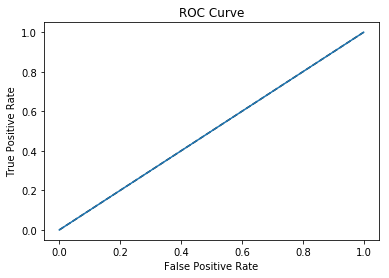

Area Under Curve: 0.5


In [19]:
generate_roc_curve(dummy_model, X_test, y_test)

## Model 1: Out of the Box Logistic Regression

This model is trained using sklearn's LogisticRegression on 70% of the entire dataset, which has over 58,000 values.

In [20]:
logreg_1 = LogisticRegression()
logreg_1.fit(X_train, y_train)

y_pred = logreg_1.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  396  1053]
 [  227 15794]]

             precision    recall  f1-score   support

          0       0.64      0.27      0.38      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470



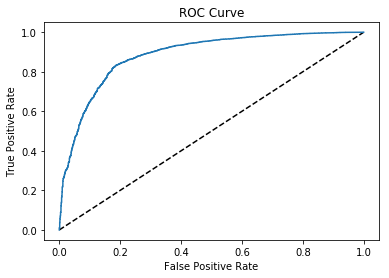

Area Under Curve: 0.8849470301423308


In [21]:
generate_roc_curve(logreg_1, X_test, y_test)

Using the out of the box logistic regression model attains a fairly high f1 score of 0.96 for predicting the 1 class, but only a score of o.38 for for 0 class. Cross-validation will be used to tune the model's hyperparameters to see if the model's performance can be improved further.

## Model 2: Tuned Logistic Regresstion

In this model, several values of the hyperparameter, C, are tested using cross-validation.

In [22]:
#Setup the hyperparameter grid
c_space = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_space}

logreg_cv = GridSearchCV(logreg_1, param_grid, cv=5)


In [23]:

logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 100}
Tuned Logistic Regression Accuracy: 0.9249809876603783


The best C value is 100, so the next model will be initialized with C=100

In [24]:
# Instantiate a logistic regression classifier using the best parameter from cross validation: logreg

logreg_tuned = LogisticRegression(C=100)
logreg_tuned.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
# generate predictions for test set and evaluate its performance

y_pred = logreg_tuned.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  396  1053]
 [  227 15794]]

             precision    recall  f1-score   support

          0       0.64      0.27      0.38      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470



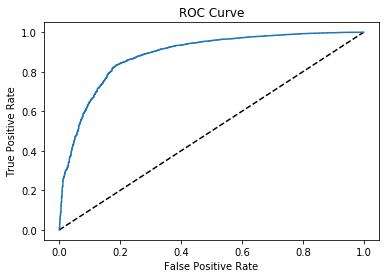

Area Under Curve: 0.8849476762921888


In [26]:
generate_roc_curve(logreg_tuned, X_test, y_test)

The performance of the model hasn't increased by much even after tuning the hyperparameter. We can also try to use feature selection to see if reducing the model's complexity will improve its performance. 

## Model 3: Tuned Logistic Regression Using Feature Selection


Feature selection was performed to examine whether removing features could improve model performance. Features were ranked by their chi-squared statistic and removed if they fell below a certain threshold.

In [27]:
test = SelectKBest(score_func=chi2, k=50)
fit = test.fit(X_encoded, rating_house_bin)

mask = test.get_support()
new_features = X_encoded.columns[mask]
new_features

Index(['total_rooms', 'rating_neighborhood', 'hh_age', 'num_bedrooms',
       'garage_No', 'garage_Yes', 'petty_crime_Agree', 'petty_crime_Disagree',
       'good_schools_Disagree', 'serious_crime_Agree',
       'tenure_Owned or being bought by someone in your household',
       'tenure_Rented', 'porch_No', 'out_water_leaks_Yes',
       'in_water_leaks_Yes', 'toilet_broke_Yes', 'paint_peeling_Yes',
       'near_abandoned_More than one vandalized building',
       'near_bar_windows_More than one building with metal bars',
       'near_trash_Large amount of trash', 'near_trash_Small amount of trash',
       'bldg_type_One-family house, detached',
       'household_type_Female householder, no husband present',
       'household_type_Married-couple family household', 'hoa_Yes',
       'dishwash_No', 'dishwash_Yes', 'washer_No',
       'dryer_Unit does not have a working clothes dryer',
       'fireplace_Has usable fireplace, not considered heating equipment',
       'fireplace_No usable fi

In [28]:
X_masked = X_encoded[new_features]


X_train, X_test, y_train, y_test = train_test_split(X_masked, y, test_size=0.3, random_state=42)

In [29]:

logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logist`ic Regression Accuracy: {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameter: {'C': 10}
Tuned Logist`ic Regression Accuracy: 0.9246866030468808


In [30]:
logreg_fs = LogisticRegression(C=10)
logreg_fs.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [31]:
y_pred = logreg_fs.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  388  1061]
 [  235 15786]]

             precision    recall  f1-score   support

          0       0.62      0.27      0.37      1449
          1       0.94      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470



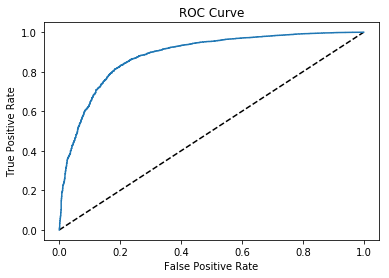

Area Under Curve: 0.8831499581574891


In [32]:
generate_roc_curve(logreg_fs, X_test, y_test)

The model’s performance actually declined when features were removed. The more features removed, the lower the model’s accuracy, although only slightly. If model complexity were a concern, features can be removed with a small loss in accuracy, but for this model, all of the features were left in the model

## Model 4: Tuned Logistic Regression with Undersampling

Because the response variable has only two classes and the positive class is present with an 11 to 1 ratio, every model is much better at predicting the modal class, 1, than it is at predicting the negative class. If the goal of the model is to perform equally as well for both classes, the dataset should be undersampled so that both response variables are present in equal amounts.

In [33]:
# create RandomUnderSampler and undersample the dataset

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_sample(X_encoded, y)

In [35]:
print(len(X_res))

9900


In [36]:
# split undersampled dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

In [37]:
# create logistic regression model using undersampled data and print model metrics

logreg_undersample = LogisticRegression()
logreg_undersample.fit(X_train, y_train)

y_pred = logreg_undersample.predict(X_test)

print_model_metrics(y_test, y_pred)

[[1199  311]
 [ 270 1190]]

             precision    recall  f1-score   support

          0       0.82      0.79      0.80      1510
          1       0.79      0.82      0.80      1460

avg / total       0.80      0.80      0.80      2970



In [38]:
# Tune hyperparameters for model created with undersampled data

logreg_cv = GridSearchCV(logreg_undersample, param_grid, cv=5)


logreg_cv.fit(X_train, y_train)

# print best parameters from cross validation
print("Tuned Logistic Regression Parameter: {}".format(logreg_cv.best_params_))
print("Tuned Logistic Regression Accuracy: {}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameter: {'C': 0.01}
Tuned Logistic Regression Accuracy: 0.8044733044733045


The best model accuracy attained was 0.80, with a C value of 0.01. The model will be retrained with C=0.1. 

In [39]:
# instantiate a logistic regression model with C=0.01 and fit to the undersampled data

logreg_undersample = LogisticRegression(C=0.01)
logreg_undersample.fit(X_train, y_train)

y_pred = logreg_undersample.predict(X_test)

print_model_metrics(y_test, y_pred)

[[1206  304]
 [ 255 1205]]

             precision    recall  f1-score   support

          0       0.83      0.80      0.81      1510
          1       0.80      0.83      0.81      1460

avg / total       0.81      0.81      0.81      2970



The model has a slightly higher precision and recall after tuning the hyperparameter.

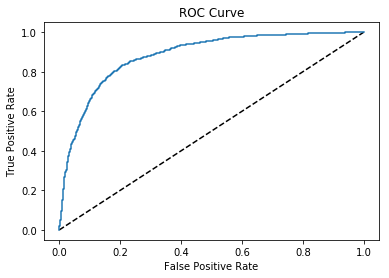

Area Under Curve: 0.8827814569536425


In [40]:
# generate an ROC curve for the tuned logistic regression model trained with undersampled data

generate_roc_curve(logreg_undersample, X_test, y_test)

The overall accuracy for the model decreased to 0.81, but the model performed equally well in predicting the positive class as it did in predicting the negative class.

## Model 5: Random Forest

A couple random forest models were also trained to see if predictions were more accurate, but tuning the model hyperparameters took much longer than logistic regression. A linear model seemed to work very well for the features in this dataset.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

In [42]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
y_pred = rf.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  457   992]
 [  409 15612]]

             precision    recall  f1-score   support

          0       0.53      0.32      0.39      1449
          1       0.94      0.97      0.96     16021

avg / total       0.91      0.92      0.91     17470



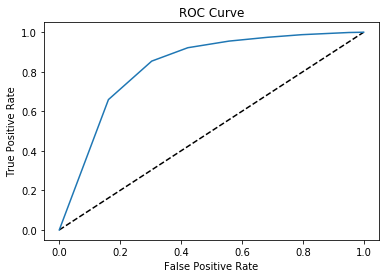

Area Under Curve: 0.8278339518925923


In [44]:
generate_roc_curve(rf, X_test, y_test)

An out of the box random forest performed about as well as a logistic regression model overall, and had a slightly higher f1-score for predicting the negative class.

## Model 6: Random Forest with Tuned Hyperparameters


The hyperparameters for the random forest were tuned to see if model performance could be improved, but moreover, reduces the likelihood of overfitting the random forest model

In [45]:
# Specify the hyperparameters to be tested with RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


Because tuning the hyperparameters would take a long time for this Random Forest, RandomizedSearchCV was used to reduce the number of test fits. 100 hyperparameter combinations were tested with a 5-fold cross-validation, for a total of 500 test fits.

In [44]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 135.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 321.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 541.8min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [45]:
# print the best parameters from RandomizedSearchCV

rf_random.best_params_

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 400}

In [47]:
# instantiate a random forest model with the best parameters from RandomizedSearchCV and test its performance

best_random_rf = RandomForestClassifier(bootstrap=False, max_depth=90, max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=400)
best_random_rf.fit(X_train, y_train)

y_pred = best_random_rf.predict(X_test)

print_model_metrics(y_test, y_pred)

[[  335  1114]
 [  157 15864]]

             precision    recall  f1-score   support

          0       0.68      0.23      0.35      1449
          1       0.93      0.99      0.96     16021

avg / total       0.91      0.93      0.91     17470



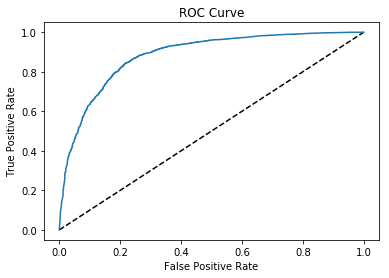

Area Under Curve: 0.8824043658364373


In [49]:
generate_roc_curve(best_random_rf, X_test, y_test)

After tuning, the model's precision and recall are comparable to the logistic regression model, but slightly lower. The area under the ROC curve is slightly less than the logistic regression model's as well.

## Conclusion

A simple logistic regression model resulted in the greatest area under the ROC curve, 0.885. A tuned logistic regression model resulted in an overall accuracy of 0.93, and a precision of 0.91. However, the model was much more likely to predict the positive class (“Satisfied with Housing”) than the negative class (“Dissatisfied with Housing”), as it was present in the dataset with an 11 to 1 ratio. 

Undersampling can be used to even out the model’s performance between the two classes, but it drops the model’s overall accuracy and precision.

The chi-squared statistic was used to attempt feature selection, but feature selection did not improve model performance. Nonetheless, the chi-squared statistic can be used to rank features on their relative importance to the response variable, and guide decision makers in how to increase the likelihood of their residents being satisfied with their housing housing.

Although a random forest model performed about as well as the logistic regression model, the time it took to train these models and tune their hyperparameters was much, much longer, and the area under the ROC curve was ultimately less than that of the logistic regression model.
